# Hierarchical Clustering

In [11]:
import kagglehub

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
path = kagglehub.dataset_download("yasserh/customer-segmentation-dataset")
filename = "Online Retail.xlsx"

In [3]:
df = pd.read_excel(path + "\\" + filename)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df_retail = df.copy() 

# remove nulls
df_retail = df_retail.dropna() 

# update data types
print(df_retail.dtypes)
df_retail["CustomerID"] = df_retail["CustomerID"].astype("str")

# calculated columns
df_retail['Amount'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_retail['DateDiff'] = max(df_retail['InvoiceDate']) - df_retail['InvoiceDate']
df_retail.head()

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,DateDiff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [5]:
df_amounts = df_retail.groupby('CustomerID')['Amount'].sum().reset_index()
df_counts = df_retail.groupby('CustomerID')['InvoiceNo'].count().reset_index().rename(columns={"InvoiceNo": "InvoiceCount"})
df_recency = df_retail.groupby('CustomerID')['DateDiff'].min().reset_index().rename(columns={"DateDiff": "DaysLastInvoice"})
df_recency["DaysLastInvoice"] = df_recency["DaysLastInvoice"].dt.days

# merge all dataframes
df_summary = pd.merge(df_amounts, df_counts, on='CustomerID', how='inner')
df_summary = pd.merge(df_summary, df_recency, on='CustomerID', how='inner')
df_summary.head()

,CustomerID,Amount,InvoiceCount,DaysLastInvoice
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [6]:
df_reduced = df_summary[["Amount", "InvoiceCount", "DaysLastInvoice"]]
df_reduced

,Amount,InvoiceCount,DaysLastInvoice
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7
4370,2094.88,756,3


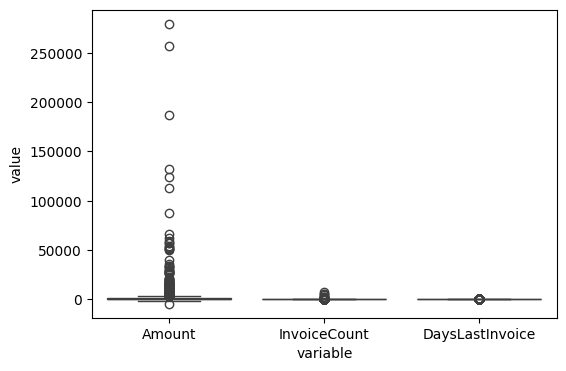

In [7]:
# check distributions
plt.figure(figsize=(6, 4))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(df_reduced))
plt.show()

In [8]:
# handle outliers
def outlier_handling(df, col):
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df_excl_outliers = outlier_handling(df_reduced, "Amount")
df_excl_outliers = outlier_handling(df_excl_outliers, "InvoiceCount")
df_excl_outliers = outlier_handling(df_excl_outliers, "DaysLastInvoice")

In [9]:
# standardise
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_excl_outliers)

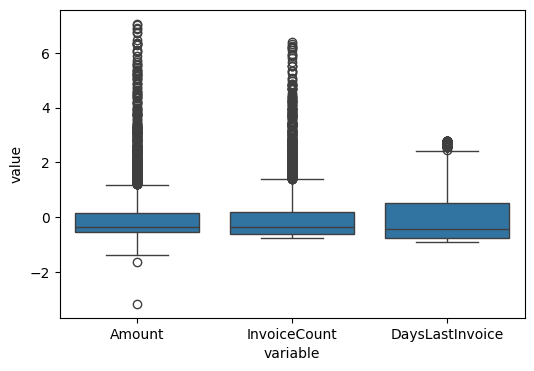

In [10]:
# check distributions again
plt.figure(figsize=(6, 4))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame(df_scaled, columns=df_excl_outliers.columns)))
plt.show()

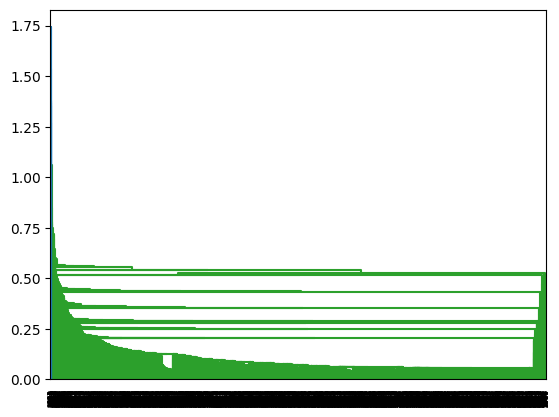

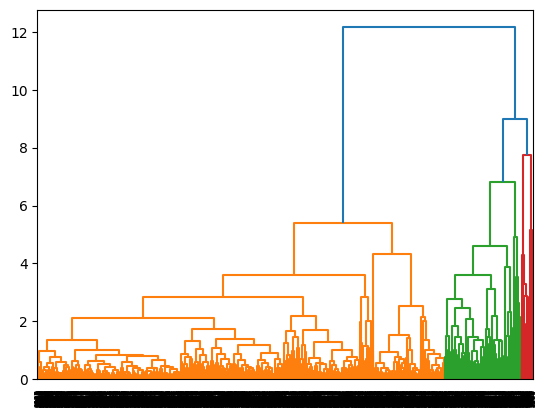

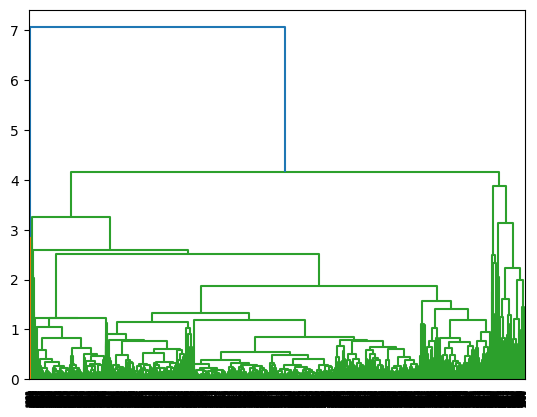

In [15]:
# Single linkage - the distance between two clusters is defined as the shortest distance between two points in each cluster
mergings = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

# complete linkage - the distance between two clusters is defined as the longest distance between two points in each cluster
mergings = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

# average linkage - the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster
mergings = linkage(df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [16]:
k = 3
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
df_final = df_excl_outliers.copy()
df_final["ClusterID"] = cluster_labels
df_final.head()

,Amount,InvoiceCount,DaysLastInvoice,ClusterID
0,0.00,2,325,0
1,4310.00,182,1,0
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,0


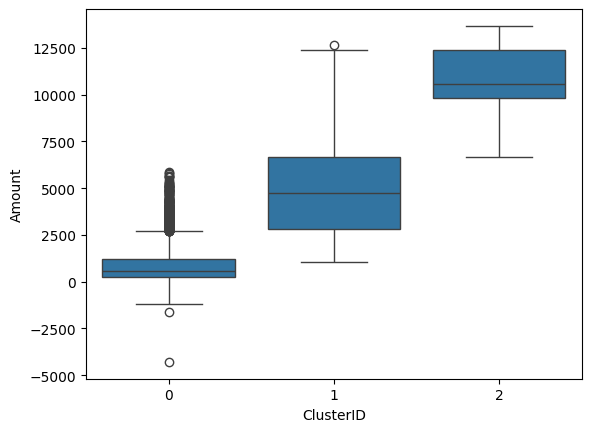

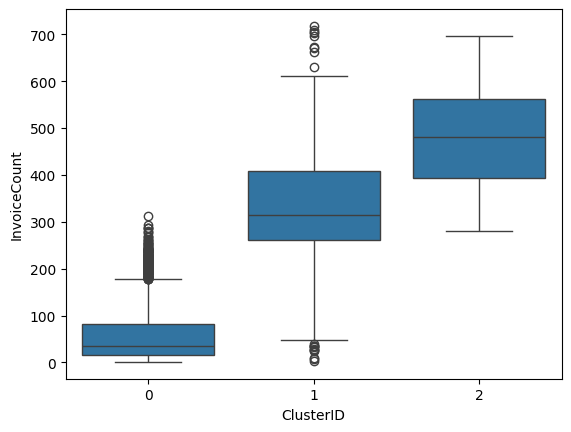

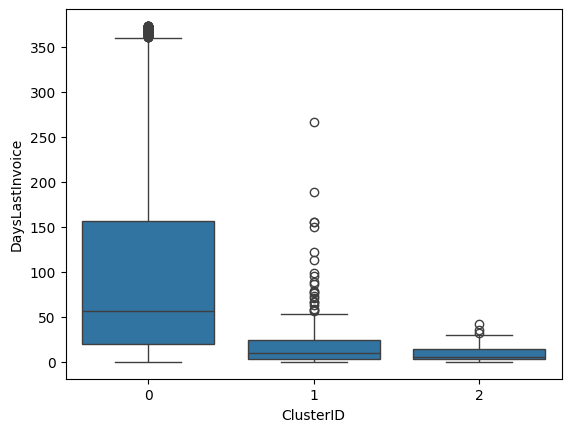

In [19]:
sns.boxplot(x='ClusterID', y='Amount', data=df_final)
plt.show()
sns.boxplot(x='ClusterID', y='InvoiceCount', data=df_final)
plt.show()
sns.boxplot(x='ClusterID', y='DaysLastInvoice', data=df_final)
plt.show()